In [3]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [4]:
ee.Initialize()

In [5]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [6]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Define_Basic_Parameters

In [46]:
# define the year_name for test, here choose these years because they represent
# Landsat8/7/5 respectively
year_name = ['2017_2019','2011_2013', '2008_2010']
percent_value = [0,1,2,3,5,7,10,20,30,50,70,100]
percent_reduction = range(100,9,-10)
tree_num = [1] + list(range(10,121,10))

##### Classify Sample_with_img_value

In [8]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# fetch the Verified_points_with_value
Sample_with_value = [ee.FeatureCollection(f'{path}/Verified_point_{year}_extract_Landsat_Fourier_Normalized_img')
                    for year in year_name] 

# fetch the Zone_points_with_value
Zone_with_value   = [ee.FeatureCollection(f'{path}/Zone_point_{year}_extract_Landsat_Fourier_Normalized_img')
                    for year in year_name]

# Merge Verified_points with Zone_points
Verified_merge_Zone = [i[0].merge(i[1]) for i in zip(Sample_with_value,Zone_with_value)]

In [11]:
def Step_1_Subset_sample(In_sample,percent):
   
    Sample_select_num = int(In_sample.size().getInfo() * percent /100)
    print(f'Percetage coresponded size is {Sample_select_num}')
    
    # add some randomness so to make the result more reliable
    return In_sample.randomColumn('x', 101).limit(Sample_select_num,'x')

def Step_2_Create_Band_Combo(fe):
    
    # use the first element to get all band name
    bands = list(fe.first().getInfo()['properties'].keys())
    
    # get the Landsat_band
    Landsat_re   = re.compile(r'^B\d')
    Landsat_band = list(filter(Landsat_re.match,bands))

    # get the Fourier_band
    Fourier_re   = re.compile(r'^EVI|NDBI|NDVI')
    Fourier_band = list(filter(Fourier_re.match,bands))
    
    # get the Mean_Normalized band
    Mean_re         = re.compile(r'^Mean')
    Mean_Normalized = list(filter(Mean_re.match,bands))
    
    # ________________________Create sample classification instaces_____________________________
    
    # create band_combinations
    band_combination = [Landsat_band,
                        Fourier_band,
                        Landsat_band + Fourier_band,
                        Landsat_band + Mean_Normalized,
                        Fourier_band + Mean_Normalized,
                        Landsat_band + Fourier_band + Mean_Normalized]
    
    # create comno_names
    global combination_name
    combination_name = ['Landsat',
                        'Fourier',
                        'Landsat_Fourier',
                        'Landsat_Mean',
                        'Fourier_Mean',
                        'Landsat_Fourier_Mean']
    
    
    return list(zip(combination_name,band_combination))

def Step_3_Create_Classification_Instance(year,verified_pt,combo,tree_list,percent):
    # Initiate the Combo_dict
    Combo_acc_dict = {}
    
    for tree in tree_list:
            
        combo_name = combo[0]
        combo_band = combo[1]

        # Instatiate the class with a name
        Sample_classification = Classification( year_name    = year,
                                              Input_band     = combo_band,
                                              Verified_point = verified_pt,
                                              Tree_num       = tree)

        # Proceed the classification
        Sample_classification.Stp_2_Classification_on_Samples()
        
        # add accuracy to the dictionary
        Combo_acc_dict.update({(year,combo_name,percent,tree) : Sample_classification.Test_sample_classification})
        
        # print out the process
        print(f'Classification of {year}_{combo_name}_pct_{percent:03}_tree_{tree:04} completed!')
        
    # get the accuracy value
    return Combo_acc_dict
    

##### Part_1: Calculate the band_combination accuracy for [verified_points ] and [Zone_sample_diff_percent]

Produce classification_instances <br>
NOTE: Here only perform percentage reduction on zone_sample

In [9]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# instantiate the combo_instance dictionary
Combo_instance = {}

# Create sample_classification instances through [year] --> [Percent] --> [band_combination] --> [Tree]
for year in year_name:
    
    Verified_sample = ee.FeatureCollection(f'{path}/Verified_point_{year}_extract_Landsat_Fourier_Normalized_img')
    Zone_sample     = ee.FeatureCollection(f'{path}/Zone_point_{year}_extract_Landsat_Fourier_Normalized_img')
    
    for pct in percent_value:
        Subset_zone_sample  = Step_1_Subset_sample(Zone_sample,pct)
        # Merge Verified_points with Zone_points
        Verified_merge_Zone = Subset_zone_sample.merge(Verified_sample)
        Band_combo          = Step_2_Create_Band_Combo(Verified_merge_Zone)
        
        for combo in Band_combo:
            Accuracy_instance = Step_3_Create_Classification_Instance(year,Verified_merge_Zone,combo,tree_num,pct) 
            Combo_instance.update(Accuracy_instance)
        

Zone sample size added is 0
Classification of 2017_2019_Landsat_pct_000_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_000_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_000_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_000_tree_0010 complete

Zone sample size added is 164
Classification of 2017_2019_Landsat_pct_002_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_002_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_002_tree_0010 comple

Zone sample size added is 411
Classification of 2017_2019_Landsat_pct_005_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_005_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_005_tree_0010 comple

Zone sample size added is 823
Classification of 2017_2019_Landsat_pct_010_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_010_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_010_tree_0010 comple

Zone sample size added is 2470
Classification of 2017_2019_Landsat_pct_030_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_030_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_030_tree_0010 compl

Zone sample size added is 5763
Classification of 2017_2019_Landsat_pct_070_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_070_tree_0001 completed!
Classification of 2017_2019_Fourier_pct_070_tree_0010 compl

Zone sample size added is 0
Classification of 2011_2013_Landsat_pct_000_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_000_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_000_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_000_tree_0010 complete

Zone sample size added is 164
Classification of 2011_2013_Landsat_pct_002_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_002_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_002_tree_0010 comple

Zone sample size added is 411
Classification of 2011_2013_Landsat_pct_005_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_005_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_005_tree_0010 comple

Zone sample size added is 823
Classification of 2011_2013_Landsat_pct_010_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_010_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_010_tree_0010 comple

Zone sample size added is 2470
Classification of 2011_2013_Landsat_pct_030_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_030_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_030_tree_0010 compl

Zone sample size added is 5763
Classification of 2011_2013_Landsat_pct_070_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_070_tree_0001 completed!
Classification of 2011_2013_Fourier_pct_070_tree_0010 compl

Zone sample size added is 0
Classification of 2008_2010_Landsat_pct_000_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_000_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_000_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_000_tree_0010 complete

Zone sample size added is 164
Classification of 2008_2010_Landsat_pct_002_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_002_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_002_tree_0010 comple

Zone sample size added is 411
Classification of 2008_2010_Landsat_pct_005_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_005_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_005_tree_0010 comple

Zone sample size added is 823
Classification of 2008_2010_Landsat_pct_010_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_010_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_010_tree_0010 comple

Zone sample size added is 2470
Classification of 2008_2010_Landsat_pct_030_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_030_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_030_tree_0010 compl

Zone sample size added is 5763
Classification of 2008_2010_Landsat_pct_070_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_070_tree_0001 completed!
Classification of 2008_2010_Fourier_pct_070_tree_0010 compl

Compute the accuracy and unpack the accuracy value

In [9]:
# innitialize the accuracy dict
Combo_acc = {}

# innitilize operation flag to report the process
Opts_flat  = 0
Opts_tatal = len(year_name) * len(combination_name) * len(percent_value) * len(tree_num)

# unpack the combo_instance through [year] --> [band_combination] --> [Percent] --> [Tree]
for year in year_name:
    for name in combination_name:
        for pct in percent_value:
            for tree in tree_num:

                Opts_flat+=1

                Combo_acc[(year,name,pct,tree)] = Accuracy_assesment(Combo_instance[(year,name,pct,tree)])\
                                              .Stp_1_Calculate_Accuracy()
                # print out the process
                print(f'{year}_{name}_pct_{pct:03}_tree_{tree:03} accuracy computation finished! ==>{Opts_flat:04}/{Opts_tatal}')
            print('_________________')

2017_2019_Landsat_pct_000_tree_001 accuracy computation finished! ==>0001/2808
2017_2019_Landsat_pct_000_tree_010 accuracy computation finished! ==>0002/2808
2017_2019_Landsat_pct_000_tree_020 accuracy computation finished! ==>0003/2808
2017_2019_Landsat_pct_000_tree_030 accuracy computation finished! ==>0004/2808
2017_2019_Landsat_pct_000_tree_040 accuracy computation finished! ==>0005/2808
2017_2019_Landsat_pct_000_tree_050 accuracy computation finished! ==>0006/2808
2017_2019_Landsat_pct_000_tree_060 accuracy computation finished! ==>0007/2808
2017_2019_Landsat_pct_000_tree_070 accuracy computation finished! ==>0008/2808
2017_2019_Landsat_pct_000_tree_080 accuracy computation finished! ==>0009/2808
2017_2019_Landsat_pct_000_tree_090 accuracy computation finished! ==>0010/2808
2017_2019_Landsat_pct_000_tree_100 accuracy computation finished! ==>0011/2808
2017_2019_Landsat_pct_000_tree_110 accuracy computation finished! ==>0012/2808
2017_2019_Landsat_pct_000_tree_120 accuracy computat

2017_2019_Landsat_pct_020_tree_120 accuracy computation finished! ==>0104/2808
_________________
2017_2019_Landsat_pct_030_tree_001 accuracy computation finished! ==>0105/2808
2017_2019_Landsat_pct_030_tree_010 accuracy computation finished! ==>0106/2808
2017_2019_Landsat_pct_030_tree_020 accuracy computation finished! ==>0107/2808
2017_2019_Landsat_pct_030_tree_030 accuracy computation finished! ==>0108/2808
2017_2019_Landsat_pct_030_tree_040 accuracy computation finished! ==>0109/2808
2017_2019_Landsat_pct_030_tree_050 accuracy computation finished! ==>0110/2808
2017_2019_Landsat_pct_030_tree_060 accuracy computation finished! ==>0111/2808
2017_2019_Landsat_pct_030_tree_070 accuracy computation finished! ==>0112/2808
2017_2019_Landsat_pct_030_tree_080 accuracy computation finished! ==>0113/2808
2017_2019_Landsat_pct_030_tree_090 accuracy computation finished! ==>0114/2808
2017_2019_Landsat_pct_030_tree_100 accuracy computation finished! ==>0115/2808
2017_2019_Landsat_pct_030_tree_110

2017_2019_Fourier_pct_003_tree_100 accuracy computation finished! ==>0206/2808
2017_2019_Fourier_pct_003_tree_110 accuracy computation finished! ==>0207/2808
2017_2019_Fourier_pct_003_tree_120 accuracy computation finished! ==>0208/2808
_________________
2017_2019_Fourier_pct_005_tree_001 accuracy computation finished! ==>0209/2808
2017_2019_Fourier_pct_005_tree_010 accuracy computation finished! ==>0210/2808
2017_2019_Fourier_pct_005_tree_020 accuracy computation finished! ==>0211/2808
2017_2019_Fourier_pct_005_tree_030 accuracy computation finished! ==>0212/2808
2017_2019_Fourier_pct_005_tree_040 accuracy computation finished! ==>0213/2808
2017_2019_Fourier_pct_005_tree_050 accuracy computation finished! ==>0214/2808
2017_2019_Fourier_pct_005_tree_060 accuracy computation finished! ==>0215/2808
2017_2019_Fourier_pct_005_tree_070 accuracy computation finished! ==>0216/2808
2017_2019_Fourier_pct_005_tree_080 accuracy computation finished! ==>0217/2808
2017_2019_Fourier_pct_005_tree_090

2017_2019_Fourier_pct_100_tree_080 accuracy computation finished! ==>0308/2808
2017_2019_Fourier_pct_100_tree_090 accuracy computation finished! ==>0309/2808
2017_2019_Fourier_pct_100_tree_100 accuracy computation finished! ==>0310/2808
2017_2019_Fourier_pct_100_tree_110 accuracy computation finished! ==>0311/2808
2017_2019_Fourier_pct_100_tree_120 accuracy computation finished! ==>0312/2808
_________________
2017_2019_Landsat_Fourier_pct_000_tree_001 accuracy computation finished! ==>0313/2808
2017_2019_Landsat_Fourier_pct_000_tree_010 accuracy computation finished! ==>0314/2808
2017_2019_Landsat_Fourier_pct_000_tree_020 accuracy computation finished! ==>0315/2808
2017_2019_Landsat_Fourier_pct_000_tree_030 accuracy computation finished! ==>0316/2808
2017_2019_Landsat_Fourier_pct_000_tree_040 accuracy computation finished! ==>0317/2808
2017_2019_Landsat_Fourier_pct_000_tree_050 accuracy computation finished! ==>0318/2808
2017_2019_Landsat_Fourier_pct_000_tree_060 accuracy computation f

2017_2019_Landsat_Fourier_pct_010_tree_110 accuracy computation finished! ==>0402/2808
2017_2019_Landsat_Fourier_pct_010_tree_120 accuracy computation finished! ==>0403/2808
_________________
2017_2019_Landsat_Fourier_pct_020_tree_001 accuracy computation finished! ==>0404/2808
2017_2019_Landsat_Fourier_pct_020_tree_010 accuracy computation finished! ==>0405/2808
2017_2019_Landsat_Fourier_pct_020_tree_020 accuracy computation finished! ==>0406/2808
2017_2019_Landsat_Fourier_pct_020_tree_030 accuracy computation finished! ==>0407/2808
2017_2019_Landsat_Fourier_pct_020_tree_040 accuracy computation finished! ==>0408/2808
2017_2019_Landsat_Fourier_pct_020_tree_050 accuracy computation finished! ==>0409/2808
2017_2019_Landsat_Fourier_pct_020_tree_060 accuracy computation finished! ==>0410/2808
2017_2019_Landsat_Fourier_pct_020_tree_070 accuracy computation finished! ==>0411/2808
2017_2019_Landsat_Fourier_pct_020_tree_080 accuracy computation finished! ==>0412/2808
2017_2019_Landsat_Fourier

2017_2019_Landsat_Mean_pct_002_tree_010 accuracy computation finished! ==>0496/2808
2017_2019_Landsat_Mean_pct_002_tree_020 accuracy computation finished! ==>0497/2808
2017_2019_Landsat_Mean_pct_002_tree_030 accuracy computation finished! ==>0498/2808
2017_2019_Landsat_Mean_pct_002_tree_040 accuracy computation finished! ==>0499/2808
2017_2019_Landsat_Mean_pct_002_tree_050 accuracy computation finished! ==>0500/2808
2017_2019_Landsat_Mean_pct_002_tree_060 accuracy computation finished! ==>0501/2808
2017_2019_Landsat_Mean_pct_002_tree_070 accuracy computation finished! ==>0502/2808
2017_2019_Landsat_Mean_pct_002_tree_080 accuracy computation finished! ==>0503/2808
2017_2019_Landsat_Mean_pct_002_tree_090 accuracy computation finished! ==>0504/2808
2017_2019_Landsat_Mean_pct_002_tree_100 accuracy computation finished! ==>0505/2808
2017_2019_Landsat_Mean_pct_002_tree_110 accuracy computation finished! ==>0506/2808
2017_2019_Landsat_Mean_pct_002_tree_120 accuracy computation finished! ==>05

2017_2019_Landsat_Mean_pct_050_tree_070 accuracy computation finished! ==>0593/2808
2017_2019_Landsat_Mean_pct_050_tree_080 accuracy computation finished! ==>0594/2808
2017_2019_Landsat_Mean_pct_050_tree_090 accuracy computation finished! ==>0595/2808
2017_2019_Landsat_Mean_pct_050_tree_100 accuracy computation finished! ==>0596/2808
2017_2019_Landsat_Mean_pct_050_tree_110 accuracy computation finished! ==>0597/2808
2017_2019_Landsat_Mean_pct_050_tree_120 accuracy computation finished! ==>0598/2808
_________________
2017_2019_Landsat_Mean_pct_070_tree_001 accuracy computation finished! ==>0599/2808
2017_2019_Landsat_Mean_pct_070_tree_010 accuracy computation finished! ==>0600/2808
2017_2019_Landsat_Mean_pct_070_tree_020 accuracy computation finished! ==>0601/2808
2017_2019_Landsat_Mean_pct_070_tree_030 accuracy computation finished! ==>0602/2808
2017_2019_Landsat_Mean_pct_070_tree_040 accuracy computation finished! ==>0603/2808
2017_2019_Landsat_Mean_pct_070_tree_050 accuracy computati

2017_2019_Fourier_Mean_pct_007_tree_001 accuracy computation finished! ==>0690/2808
2017_2019_Fourier_Mean_pct_007_tree_010 accuracy computation finished! ==>0691/2808
2017_2019_Fourier_Mean_pct_007_tree_020 accuracy computation finished! ==>0692/2808
2017_2019_Fourier_Mean_pct_007_tree_030 accuracy computation finished! ==>0693/2808
2017_2019_Fourier_Mean_pct_007_tree_040 accuracy computation finished! ==>0694/2808
2017_2019_Fourier_Mean_pct_007_tree_050 accuracy computation finished! ==>0695/2808
2017_2019_Fourier_Mean_pct_007_tree_060 accuracy computation finished! ==>0696/2808
2017_2019_Fourier_Mean_pct_007_tree_070 accuracy computation finished! ==>0697/2808
2017_2019_Fourier_Mean_pct_007_tree_080 accuracy computation finished! ==>0698/2808
2017_2019_Fourier_Mean_pct_007_tree_090 accuracy computation finished! ==>0699/2808
2017_2019_Fourier_Mean_pct_007_tree_100 accuracy computation finished! ==>0700/2808
2017_2019_Fourier_Mean_pct_007_tree_110 accuracy computation finished! ==>07

2017_2019_Landsat_Fourier_Mean_pct_000_tree_050 accuracy computation finished! ==>0786/2808
2017_2019_Landsat_Fourier_Mean_pct_000_tree_060 accuracy computation finished! ==>0787/2808
2017_2019_Landsat_Fourier_Mean_pct_000_tree_070 accuracy computation finished! ==>0788/2808
2017_2019_Landsat_Fourier_Mean_pct_000_tree_080 accuracy computation finished! ==>0789/2808
2017_2019_Landsat_Fourier_Mean_pct_000_tree_090 accuracy computation finished! ==>0790/2808
2017_2019_Landsat_Fourier_Mean_pct_000_tree_100 accuracy computation finished! ==>0791/2808
2017_2019_Landsat_Fourier_Mean_pct_000_tree_110 accuracy computation finished! ==>0792/2808
2017_2019_Landsat_Fourier_Mean_pct_000_tree_120 accuracy computation finished! ==>0793/2808
_________________
2017_2019_Landsat_Fourier_Mean_pct_001_tree_001 accuracy computation finished! ==>0794/2808
2017_2019_Landsat_Fourier_Mean_pct_001_tree_010 accuracy computation finished! ==>0795/2808
2017_2019_Landsat_Fourier_Mean_pct_001_tree_020 accuracy compu

2017_2019_Landsat_Fourier_Mean_pct_020_tree_020 accuracy computation finished! ==>0874/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_030 accuracy computation finished! ==>0875/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_040 accuracy computation finished! ==>0876/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_050 accuracy computation finished! ==>0877/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_060 accuracy computation finished! ==>0878/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_070 accuracy computation finished! ==>0879/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_080 accuracy computation finished! ==>0880/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_090 accuracy computation finished! ==>0881/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_100 accuracy computation finished! ==>0882/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_110 accuracy computation finished! ==>0883/2808
2017_2019_Landsat_Fourier_Mean_pct_020_tree_120 accuracy computation finished! =

2011_2013_Landsat_pct_002_tree_030 accuracy computation finished! ==>0966/2808
2011_2013_Landsat_pct_002_tree_040 accuracy computation finished! ==>0967/2808
2011_2013_Landsat_pct_002_tree_050 accuracy computation finished! ==>0968/2808
2011_2013_Landsat_pct_002_tree_060 accuracy computation finished! ==>0969/2808
2011_2013_Landsat_pct_002_tree_070 accuracy computation finished! ==>0970/2808
2011_2013_Landsat_pct_002_tree_080 accuracy computation finished! ==>0971/2808
2011_2013_Landsat_pct_002_tree_090 accuracy computation finished! ==>0972/2808
2011_2013_Landsat_pct_002_tree_100 accuracy computation finished! ==>0973/2808
2011_2013_Landsat_pct_002_tree_110 accuracy computation finished! ==>0974/2808
2011_2013_Landsat_pct_002_tree_120 accuracy computation finished! ==>0975/2808
_________________
2011_2013_Landsat_pct_003_tree_001 accuracy computation finished! ==>0976/2808
2011_2013_Landsat_pct_003_tree_010 accuracy computation finished! ==>0977/2808
2011_2013_Landsat_pct_003_tree_020

2011_2013_Landsat_pct_070_tree_010 accuracy computation finished! ==>1068/2808
2011_2013_Landsat_pct_070_tree_020 accuracy computation finished! ==>1069/2808
2011_2013_Landsat_pct_070_tree_030 accuracy computation finished! ==>1070/2808
2011_2013_Landsat_pct_070_tree_040 accuracy computation finished! ==>1071/2808
2011_2013_Landsat_pct_070_tree_050 accuracy computation finished! ==>1072/2808
2011_2013_Landsat_pct_070_tree_060 accuracy computation finished! ==>1073/2808
2011_2013_Landsat_pct_070_tree_070 accuracy computation finished! ==>1074/2808
2011_2013_Landsat_pct_070_tree_080 accuracy computation finished! ==>1075/2808
2011_2013_Landsat_pct_070_tree_090 accuracy computation finished! ==>1076/2808
2011_2013_Landsat_pct_070_tree_100 accuracy computation finished! ==>1077/2808
2011_2013_Landsat_pct_070_tree_110 accuracy computation finished! ==>1078/2808
2011_2013_Landsat_pct_070_tree_120 accuracy computation finished! ==>1079/2808
_________________
2011_2013_Landsat_pct_100_tree_001

2011_2013_Fourier_pct_010_tree_001 accuracy computation finished! ==>1171/2808
2011_2013_Fourier_pct_010_tree_010 accuracy computation finished! ==>1172/2808
2011_2013_Fourier_pct_010_tree_020 accuracy computation finished! ==>1173/2808
2011_2013_Fourier_pct_010_tree_030 accuracy computation finished! ==>1174/2808
2011_2013_Fourier_pct_010_tree_040 accuracy computation finished! ==>1175/2808
2011_2013_Fourier_pct_010_tree_050 accuracy computation finished! ==>1176/2808
2011_2013_Fourier_pct_010_tree_060 accuracy computation finished! ==>1177/2808
2011_2013_Fourier_pct_010_tree_070 accuracy computation finished! ==>1178/2808
2011_2013_Fourier_pct_010_tree_080 accuracy computation finished! ==>1179/2808
2011_2013_Fourier_pct_010_tree_090 accuracy computation finished! ==>1180/2808
2011_2013_Fourier_pct_010_tree_100 accuracy computation finished! ==>1181/2808
2011_2013_Fourier_pct_010_tree_110 accuracy computation finished! ==>1182/2808
2011_2013_Fourier_pct_010_tree_120 accuracy computat

2011_2013_Landsat_Fourier_pct_001_tree_090 accuracy computation finished! ==>1271/2808
2011_2013_Landsat_Fourier_pct_001_tree_100 accuracy computation finished! ==>1272/2808
2011_2013_Landsat_Fourier_pct_001_tree_110 accuracy computation finished! ==>1273/2808
2011_2013_Landsat_Fourier_pct_001_tree_120 accuracy computation finished! ==>1274/2808
_________________
2011_2013_Landsat_Fourier_pct_002_tree_001 accuracy computation finished! ==>1275/2808
2011_2013_Landsat_Fourier_pct_002_tree_010 accuracy computation finished! ==>1276/2808
2011_2013_Landsat_Fourier_pct_002_tree_020 accuracy computation finished! ==>1277/2808
2011_2013_Landsat_Fourier_pct_002_tree_030 accuracy computation finished! ==>1278/2808
2011_2013_Landsat_Fourier_pct_002_tree_040 accuracy computation finished! ==>1279/2808
2011_2013_Landsat_Fourier_pct_002_tree_050 accuracy computation finished! ==>1280/2808
2011_2013_Landsat_Fourier_pct_002_tree_060 accuracy computation finished! ==>1281/2808
2011_2013_Landsat_Fourier

2011_2013_Landsat_Fourier_pct_030_tree_110 accuracy computation finished! ==>1364/2808
2011_2013_Landsat_Fourier_pct_030_tree_120 accuracy computation finished! ==>1365/2808
_________________
2011_2013_Landsat_Fourier_pct_050_tree_001 accuracy computation finished! ==>1366/2808
2011_2013_Landsat_Fourier_pct_050_tree_010 accuracy computation finished! ==>1367/2808
2011_2013_Landsat_Fourier_pct_050_tree_020 accuracy computation finished! ==>1368/2808
2011_2013_Landsat_Fourier_pct_050_tree_030 accuracy computation finished! ==>1369/2808
2011_2013_Landsat_Fourier_pct_050_tree_040 accuracy computation finished! ==>1370/2808
2011_2013_Landsat_Fourier_pct_050_tree_050 accuracy computation finished! ==>1371/2808
2011_2013_Landsat_Fourier_pct_050_tree_060 accuracy computation finished! ==>1372/2808
2011_2013_Landsat_Fourier_pct_050_tree_070 accuracy computation finished! ==>1373/2808
2011_2013_Landsat_Fourier_pct_050_tree_080 accuracy computation finished! ==>1374/2808
2011_2013_Landsat_Fourier

2011_2013_Landsat_Mean_pct_005_tree_020 accuracy computation finished! ==>1459/2808
2011_2013_Landsat_Mean_pct_005_tree_030 accuracy computation finished! ==>1460/2808
2011_2013_Landsat_Mean_pct_005_tree_040 accuracy computation finished! ==>1461/2808
2011_2013_Landsat_Mean_pct_005_tree_050 accuracy computation finished! ==>1462/2808
2011_2013_Landsat_Mean_pct_005_tree_060 accuracy computation finished! ==>1463/2808
2011_2013_Landsat_Mean_pct_005_tree_070 accuracy computation finished! ==>1464/2808
2011_2013_Landsat_Mean_pct_005_tree_080 accuracy computation finished! ==>1465/2808
2011_2013_Landsat_Mean_pct_005_tree_090 accuracy computation finished! ==>1466/2808
2011_2013_Landsat_Mean_pct_005_tree_100 accuracy computation finished! ==>1467/2808
2011_2013_Landsat_Mean_pct_005_tree_110 accuracy computation finished! ==>1468/2808
2011_2013_Landsat_Mean_pct_005_tree_120 accuracy computation finished! ==>1469/2808
_________________
2011_2013_Landsat_Mean_pct_007_tree_001 accuracy computati

2011_2013_Landsat_Mean_pct_100_tree_080 accuracy computation finished! ==>1556/2808
2011_2013_Landsat_Mean_pct_100_tree_090 accuracy computation finished! ==>1557/2808
2011_2013_Landsat_Mean_pct_100_tree_100 accuracy computation finished! ==>1558/2808
2011_2013_Landsat_Mean_pct_100_tree_110 accuracy computation finished! ==>1559/2808
2011_2013_Landsat_Mean_pct_100_tree_120 accuracy computation finished! ==>1560/2808
_________________
2011_2013_Fourier_Mean_pct_000_tree_001 accuracy computation finished! ==>1561/2808
2011_2013_Fourier_Mean_pct_000_tree_010 accuracy computation finished! ==>1562/2808
2011_2013_Fourier_Mean_pct_000_tree_020 accuracy computation finished! ==>1563/2808
2011_2013_Fourier_Mean_pct_000_tree_030 accuracy computation finished! ==>1564/2808
2011_2013_Fourier_Mean_pct_000_tree_040 accuracy computation finished! ==>1565/2808
2011_2013_Fourier_Mean_pct_000_tree_050 accuracy computation finished! ==>1566/2808
2011_2013_Fourier_Mean_pct_000_tree_060 accuracy computati

2011_2013_Fourier_Mean_pct_020_tree_001 accuracy computation finished! ==>1652/2808
2011_2013_Fourier_Mean_pct_020_tree_010 accuracy computation finished! ==>1653/2808
2011_2013_Fourier_Mean_pct_020_tree_020 accuracy computation finished! ==>1654/2808
2011_2013_Fourier_Mean_pct_020_tree_030 accuracy computation finished! ==>1655/2808
2011_2013_Fourier_Mean_pct_020_tree_040 accuracy computation finished! ==>1656/2808
2011_2013_Fourier_Mean_pct_020_tree_050 accuracy computation finished! ==>1657/2808
2011_2013_Fourier_Mean_pct_020_tree_060 accuracy computation finished! ==>1658/2808
2011_2013_Fourier_Mean_pct_020_tree_070 accuracy computation finished! ==>1659/2808
2011_2013_Fourier_Mean_pct_020_tree_080 accuracy computation finished! ==>1660/2808
2011_2013_Fourier_Mean_pct_020_tree_090 accuracy computation finished! ==>1661/2808
2011_2013_Fourier_Mean_pct_020_tree_100 accuracy computation finished! ==>1662/2808
2011_2013_Fourier_Mean_pct_020_tree_110 accuracy computation finished! ==>16

2011_2013_Landsat_Fourier_Mean_pct_002_tree_030 accuracy computation finished! ==>1746/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_040 accuracy computation finished! ==>1747/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_050 accuracy computation finished! ==>1748/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_060 accuracy computation finished! ==>1749/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_070 accuracy computation finished! ==>1750/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_080 accuracy computation finished! ==>1751/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_090 accuracy computation finished! ==>1752/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_100 accuracy computation finished! ==>1753/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_110 accuracy computation finished! ==>1754/2808
2011_2013_Landsat_Fourier_Mean_pct_002_tree_120 accuracy computation finished! ==>1755/2808
_________________
2011_2013_Landsat_Fourier_Mean_pct_003_tree_001 accuracy compu

2011_2013_Landsat_Fourier_Mean_pct_050_tree_001 accuracy computation finished! ==>1834/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_010 accuracy computation finished! ==>1835/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_020 accuracy computation finished! ==>1836/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_030 accuracy computation finished! ==>1837/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_040 accuracy computation finished! ==>1838/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_050 accuracy computation finished! ==>1839/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_060 accuracy computation finished! ==>1840/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_070 accuracy computation finished! ==>1841/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_080 accuracy computation finished! ==>1842/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_090 accuracy computation finished! ==>1843/2808
2011_2013_Landsat_Fourier_Mean_pct_050_tree_100 accuracy computation finished! =

2008_2010_Landsat_pct_005_tree_050 accuracy computation finished! ==>1930/2808
2008_2010_Landsat_pct_005_tree_060 accuracy computation finished! ==>1931/2808
2008_2010_Landsat_pct_005_tree_070 accuracy computation finished! ==>1932/2808
2008_2010_Landsat_pct_005_tree_080 accuracy computation finished! ==>1933/2808
2008_2010_Landsat_pct_005_tree_090 accuracy computation finished! ==>1934/2808
2008_2010_Landsat_pct_005_tree_100 accuracy computation finished! ==>1935/2808
2008_2010_Landsat_pct_005_tree_110 accuracy computation finished! ==>1936/2808
2008_2010_Landsat_pct_005_tree_120 accuracy computation finished! ==>1937/2808
_________________
2008_2010_Landsat_pct_007_tree_001 accuracy computation finished! ==>1938/2808
2008_2010_Landsat_pct_007_tree_010 accuracy computation finished! ==>1939/2808
2008_2010_Landsat_pct_007_tree_020 accuracy computation finished! ==>1940/2808
2008_2010_Landsat_pct_007_tree_030 accuracy computation finished! ==>1941/2808
2008_2010_Landsat_pct_007_tree_040

2008_2010_Fourier_pct_000_tree_030 accuracy computation finished! ==>2032/2808
2008_2010_Fourier_pct_000_tree_040 accuracy computation finished! ==>2033/2808
2008_2010_Fourier_pct_000_tree_050 accuracy computation finished! ==>2034/2808
2008_2010_Fourier_pct_000_tree_060 accuracy computation finished! ==>2035/2808
2008_2010_Fourier_pct_000_tree_070 accuracy computation finished! ==>2036/2808
2008_2010_Fourier_pct_000_tree_080 accuracy computation finished! ==>2037/2808
2008_2010_Fourier_pct_000_tree_090 accuracy computation finished! ==>2038/2808
2008_2010_Fourier_pct_000_tree_100 accuracy computation finished! ==>2039/2808
2008_2010_Fourier_pct_000_tree_110 accuracy computation finished! ==>2040/2808
2008_2010_Fourier_pct_000_tree_120 accuracy computation finished! ==>2041/2808
_________________
2008_2010_Fourier_pct_001_tree_001 accuracy computation finished! ==>2042/2808
2008_2010_Fourier_pct_001_tree_010 accuracy computation finished! ==>2043/2808
2008_2010_Fourier_pct_001_tree_020

2008_2010_Fourier_pct_030_tree_010 accuracy computation finished! ==>2134/2808
2008_2010_Fourier_pct_030_tree_020 accuracy computation finished! ==>2135/2808
2008_2010_Fourier_pct_030_tree_030 accuracy computation finished! ==>2136/2808
2008_2010_Fourier_pct_030_tree_040 accuracy computation finished! ==>2137/2808
2008_2010_Fourier_pct_030_tree_050 accuracy computation finished! ==>2138/2808
2008_2010_Fourier_pct_030_tree_060 accuracy computation finished! ==>2139/2808
2008_2010_Fourier_pct_030_tree_070 accuracy computation finished! ==>2140/2808
2008_2010_Fourier_pct_030_tree_080 accuracy computation finished! ==>2141/2808
2008_2010_Fourier_pct_030_tree_090 accuracy computation finished! ==>2142/2808
2008_2010_Fourier_pct_030_tree_100 accuracy computation finished! ==>2143/2808
2008_2010_Fourier_pct_030_tree_110 accuracy computation finished! ==>2144/2808
2008_2010_Fourier_pct_030_tree_120 accuracy computation finished! ==>2145/2808
_________________
2008_2010_Fourier_pct_050_tree_001

2008_2010_Landsat_Fourier_pct_003_tree_080 accuracy computation finished! ==>2232/2808
2008_2010_Landsat_Fourier_pct_003_tree_090 accuracy computation finished! ==>2233/2808
2008_2010_Landsat_Fourier_pct_003_tree_100 accuracy computation finished! ==>2234/2808
2008_2010_Landsat_Fourier_pct_003_tree_110 accuracy computation finished! ==>2235/2808
2008_2010_Landsat_Fourier_pct_003_tree_120 accuracy computation finished! ==>2236/2808
_________________
2008_2010_Landsat_Fourier_pct_005_tree_001 accuracy computation finished! ==>2237/2808
2008_2010_Landsat_Fourier_pct_005_tree_010 accuracy computation finished! ==>2238/2808
2008_2010_Landsat_Fourier_pct_005_tree_020 accuracy computation finished! ==>2239/2808
2008_2010_Landsat_Fourier_pct_005_tree_030 accuracy computation finished! ==>2240/2808
2008_2010_Landsat_Fourier_pct_005_tree_040 accuracy computation finished! ==>2241/2808
2008_2010_Landsat_Fourier_pct_005_tree_050 accuracy computation finished! ==>2242/2808
2008_2010_Landsat_Fourier

2008_2010_Landsat_Fourier_pct_070_tree_100 accuracy computation finished! ==>2325/2808
2008_2010_Landsat_Fourier_pct_070_tree_110 accuracy computation finished! ==>2326/2808
2008_2010_Landsat_Fourier_pct_070_tree_120 accuracy computation finished! ==>2327/2808
_________________
2008_2010_Landsat_Fourier_pct_100_tree_001 accuracy computation finished! ==>2328/2808
2008_2010_Landsat_Fourier_pct_100_tree_010 accuracy computation finished! ==>2329/2808
2008_2010_Landsat_Fourier_pct_100_tree_020 accuracy computation finished! ==>2330/2808
2008_2010_Landsat_Fourier_pct_100_tree_030 accuracy computation finished! ==>2331/2808
2008_2010_Landsat_Fourier_pct_100_tree_040 accuracy computation finished! ==>2332/2808
2008_2010_Landsat_Fourier_pct_100_tree_050 accuracy computation finished! ==>2333/2808
2008_2010_Landsat_Fourier_pct_100_tree_060 accuracy computation finished! ==>2334/2808
2008_2010_Landsat_Fourier_pct_100_tree_070 accuracy computation finished! ==>2335/2808
2008_2010_Landsat_Fourier

2008_2010_Landsat_Mean_pct_010_tree_020 accuracy computation finished! ==>2421/2808
2008_2010_Landsat_Mean_pct_010_tree_030 accuracy computation finished! ==>2422/2808
2008_2010_Landsat_Mean_pct_010_tree_040 accuracy computation finished! ==>2423/2808
2008_2010_Landsat_Mean_pct_010_tree_050 accuracy computation finished! ==>2424/2808
2008_2010_Landsat_Mean_pct_010_tree_060 accuracy computation finished! ==>2425/2808
2008_2010_Landsat_Mean_pct_010_tree_070 accuracy computation finished! ==>2426/2808
2008_2010_Landsat_Mean_pct_010_tree_080 accuracy computation finished! ==>2427/2808
2008_2010_Landsat_Mean_pct_010_tree_090 accuracy computation finished! ==>2428/2808
2008_2010_Landsat_Mean_pct_010_tree_100 accuracy computation finished! ==>2429/2808
2008_2010_Landsat_Mean_pct_010_tree_110 accuracy computation finished! ==>2430/2808
2008_2010_Landsat_Mean_pct_010_tree_120 accuracy computation finished! ==>2431/2808
_________________
2008_2010_Landsat_Mean_pct_020_tree_001 accuracy computati

2008_2010_Fourier_Mean_pct_001_tree_080 accuracy computation finished! ==>2518/2808
2008_2010_Fourier_Mean_pct_001_tree_090 accuracy computation finished! ==>2519/2808
2008_2010_Fourier_Mean_pct_001_tree_100 accuracy computation finished! ==>2520/2808
2008_2010_Fourier_Mean_pct_001_tree_110 accuracy computation finished! ==>2521/2808
2008_2010_Fourier_Mean_pct_001_tree_120 accuracy computation finished! ==>2522/2808
_________________
2008_2010_Fourier_Mean_pct_002_tree_001 accuracy computation finished! ==>2523/2808
2008_2010_Fourier_Mean_pct_002_tree_010 accuracy computation finished! ==>2524/2808
2008_2010_Fourier_Mean_pct_002_tree_020 accuracy computation finished! ==>2525/2808
2008_2010_Fourier_Mean_pct_002_tree_030 accuracy computation finished! ==>2526/2808
2008_2010_Fourier_Mean_pct_002_tree_040 accuracy computation finished! ==>2527/2808
2008_2010_Fourier_Mean_pct_002_tree_050 accuracy computation finished! ==>2528/2808
2008_2010_Fourier_Mean_pct_002_tree_060 accuracy computati

2008_2010_Fourier_Mean_pct_050_tree_001 accuracy computation finished! ==>2614/2808
2008_2010_Fourier_Mean_pct_050_tree_010 accuracy computation finished! ==>2615/2808
2008_2010_Fourier_Mean_pct_050_tree_020 accuracy computation finished! ==>2616/2808
2008_2010_Fourier_Mean_pct_050_tree_030 accuracy computation finished! ==>2617/2808
2008_2010_Fourier_Mean_pct_050_tree_040 accuracy computation finished! ==>2618/2808
2008_2010_Fourier_Mean_pct_050_tree_050 accuracy computation finished! ==>2619/2808
2008_2010_Fourier_Mean_pct_050_tree_060 accuracy computation finished! ==>2620/2808
2008_2010_Fourier_Mean_pct_050_tree_070 accuracy computation finished! ==>2621/2808
2008_2010_Fourier_Mean_pct_050_tree_080 accuracy computation finished! ==>2622/2808
2008_2010_Fourier_Mean_pct_050_tree_090 accuracy computation finished! ==>2623/2808
2008_2010_Fourier_Mean_pct_050_tree_100 accuracy computation finished! ==>2624/2808
2008_2010_Fourier_Mean_pct_050_tree_110 accuracy computation finished! ==>26

2008_2010_Landsat_Fourier_Mean_pct_005_tree_010 accuracy computation finished! ==>2706/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_020 accuracy computation finished! ==>2707/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_030 accuracy computation finished! ==>2708/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_040 accuracy computation finished! ==>2709/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_050 accuracy computation finished! ==>2710/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_060 accuracy computation finished! ==>2711/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_070 accuracy computation finished! ==>2712/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_080 accuracy computation finished! ==>2713/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_090 accuracy computation finished! ==>2714/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_100 accuracy computation finished! ==>2715/2808
2008_2010_Landsat_Fourier_Mean_pct_005_tree_110 accuracy computation finished! =

2008_2010_Landsat_Fourier_Mean_pct_070_tree_110 accuracy computation finished! ==>2794/2808
2008_2010_Landsat_Fourier_Mean_pct_070_tree_120 accuracy computation finished! ==>2795/2808
_________________
2008_2010_Landsat_Fourier_Mean_pct_100_tree_001 accuracy computation finished! ==>2796/2808
2008_2010_Landsat_Fourier_Mean_pct_100_tree_010 accuracy computation finished! ==>2797/2808
2008_2010_Landsat_Fourier_Mean_pct_100_tree_020 accuracy computation finished! ==>2798/2808
2008_2010_Landsat_Fourier_Mean_pct_100_tree_030 accuracy computation finished! ==>2799/2808
2008_2010_Landsat_Fourier_Mean_pct_100_tree_040 accuracy computation finished! ==>2800/2808
2008_2010_Landsat_Fourier_Mean_pct_100_tree_050 accuracy computation finished! ==>2801/2808
2008_2010_Landsat_Fourier_Mean_pct_100_tree_060 accuracy computation finished! ==>2802/2808
2008_2010_Landsat_Fourier_Mean_pct_100_tree_070 accuracy computation finished! ==>2803/2808
2008_2010_Landsat_Fourier_Mean_pct_100_tree_080 accuracy compu

In [10]:
# # convert the accuracy dicionary into a dataframe
# Combo_acc_df = pd.DataFrame(Combo_acc).T
# Combo_acc_df.index.names = ['Year','Combo','Percent','Tree']

# # save the dataframe
# Combo_acc_df.to_csv('./Step_2_result/Classification_ACC_with_zone_point.csv')

##### Part_2: Calculate the band_combination accuracy for [verified_points ] and [Village_point_1990_1992] with different percentage reduction

Produce classification_instances

In [43]:
pct

0

In [40]:
Step_1_Subset_sample(Verified_sample,pct).size().getInfo()

Zone sample size added is 0


0

In [47]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# instantiate the combo_instance dictionary
Combo_instance_with_village = {}

# Create sample_classification instances through [year] --> [Percent] --> [band_combination] --> [Tree]
for year in year_name:
    
    # import samples
    Verified_sample = ee.FeatureCollection(f'{path}/Verified_point_{year}_extract_Landsat_Fourier_Normalized_img')\
                        .filterMetadata('Built', 'equals', 0)
    Village_sample  = ee.FeatureCollection(f'{path}/Village_point_{year}_extract_Landsat_Fourier_Normalized_img')
    
    # make sure they are the same size.
    min_size = min(Verified_sample.size().getInfo(),Village_sample.size().getInfo())
    Verified_sample = Verified_sample.randomColumn('z', 101).limit(min_size,'z')
    Village_sample  = Village_sample.randomColumn('z', 101).limit(min_size,'z')
    
    for pct in percent_reduction:
        
        # Create percentage_reduced samples, only use non-built points from verified points
        Subset_verified_sample  = Step_1_Subset_sample(Verified_sample,pct)
        Subset_village_sample   = Step_1_Subset_sample(Village_sample,pct)
        
        # Merge Verified_points with Zone_points
        Sample_merge = Subset_verified_sample.merge(Subset_village_sample)
        
        # Get the band_combo names
        Band_combo   = Step_2_Create_Band_Combo(Sample_merge)
        
        for combo in Band_combo:
            Accuracy_instance = Step_3_Create_Classification_Instance(year,Sample_merge,combo,tree_num,pct) 
            Combo_instance_with_village.update(Accuracy_instance)
        

Zone sample size added is 8753
Zone sample size added is 8753
Classification of 2017_2019_Landsat_pct_100_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_100_tree_0001 completed!
Classification of 2017_2019_

Zone sample size added is 7002
Zone sample size added is 7002
Classification of 2017_2019_Landsat_pct_080_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_080_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_080_tree_0001 completed!
Classification of 2017_2019_

Zone sample size added is 5251
Zone sample size added is 5251
Classification of 2017_2019_Landsat_pct_060_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_060_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_060_tree_0001 completed!
Classification of 2017_2019_

Zone sample size added is 3501
Zone sample size added is 3501
Classification of 2017_2019_Landsat_pct_040_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_040_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_040_tree_0001 completed!
Classification of 2017_2019_

Zone sample size added is 1750
Zone sample size added is 1750
Classification of 2017_2019_Landsat_pct_020_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_020_tree_0001 completed!
Classification of 2017_2019_

Zone sample size added is 8571
Zone sample size added is 8571
Classification of 2011_2013_Landsat_pct_100_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_100_tree_0001 completed!
Classification of 2011_2013_

Zone sample size added is 6856
Zone sample size added is 6856
Classification of 2011_2013_Landsat_pct_080_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_080_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_080_tree_0001 completed!
Classification of 2011_2013_

Zone sample size added is 5142
Zone sample size added is 5142
Classification of 2011_2013_Landsat_pct_060_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_060_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_060_tree_0001 completed!
Classification of 2011_2013_

Zone sample size added is 3428
Zone sample size added is 3428
Classification of 2011_2013_Landsat_pct_040_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_040_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_040_tree_0001 completed!
Classification of 2011_2013_

Zone sample size added is 1714
Zone sample size added is 1714
Classification of 2011_2013_Landsat_pct_020_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_020_tree_0001 completed!
Classification of 2011_2013_

Zone sample size added is 8804
Zone sample size added is 8804
Classification of 2008_2010_Landsat_pct_100_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_100_tree_0001 completed!
Classification of 2008_2010_

Zone sample size added is 7043
Zone sample size added is 7043
Classification of 2008_2010_Landsat_pct_080_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_080_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_080_tree_0001 completed!
Classification of 2008_2010_

Zone sample size added is 5282
Zone sample size added is 5282
Classification of 2008_2010_Landsat_pct_060_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_060_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_060_tree_0001 completed!
Classification of 2008_2010_

Zone sample size added is 3521
Zone sample size added is 3521
Classification of 2008_2010_Landsat_pct_040_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_040_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_040_tree_0001 completed!
Classification of 2008_2010_

Zone sample size added is 1760
Zone sample size added is 1760
Classification of 2008_2010_Landsat_pct_020_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_020_tree_0001 completed!
Classification of 2008_2010_

Produce classification_instances <br>
NOTE: Here only perform percentage reduction BOTH on  Verified_sample and Village_Sample

In [49]:
# innitialize the accuracy dict
Combo_acc_with_village = {}

# innitilize operation flag to report the process
Opts_flat  = 0
Opts_tatal = len(year_name) * len(combination_name) * len(percent_reduction) * len(tree_num)

# unpack the combo_instance through [year] --> [band_combination] --> [Percent] --> [Tree]
for year in year_name:
    for name in combination_name:
        for pct in percent_reduction:
            for tree in tree_num:

                Opts_flat+=1

                Combo_acc_with_village[(year,name,pct,tree)] = Accuracy_assesment(Combo_instance_with_village[(year,name,pct,tree)])\
                                              .Stp_1_Calculate_Accuracy()
                # print out the process
                print(f'{year}_{name}_pct_{pct:03}_tree_{tree:03} accuracy computation finished! ==>{Opts_flat:04}/{Opts_tatal}')
            print('_________________')

2017_2019_Landsat_pct_100_tree_001 accuracy computation finished! ==>0001/2340
2017_2019_Landsat_pct_100_tree_010 accuracy computation finished! ==>0002/2340
2017_2019_Landsat_pct_100_tree_020 accuracy computation finished! ==>0003/2340
2017_2019_Landsat_pct_100_tree_030 accuracy computation finished! ==>0004/2340
2017_2019_Landsat_pct_100_tree_040 accuracy computation finished! ==>0005/2340
2017_2019_Landsat_pct_100_tree_050 accuracy computation finished! ==>0006/2340
2017_2019_Landsat_pct_100_tree_060 accuracy computation finished! ==>0007/2340
2017_2019_Landsat_pct_100_tree_070 accuracy computation finished! ==>0008/2340
2017_2019_Landsat_pct_100_tree_080 accuracy computation finished! ==>0009/2340
2017_2019_Landsat_pct_100_tree_090 accuracy computation finished! ==>0010/2340
2017_2019_Landsat_pct_100_tree_100 accuracy computation finished! ==>0011/2340
2017_2019_Landsat_pct_100_tree_110 accuracy computation finished! ==>0012/2340
2017_2019_Landsat_pct_100_tree_120 accuracy computat

2017_2019_Landsat_pct_030_tree_120 accuracy computation finished! ==>0104/2340
_________________


KeyboardInterrupt: 

In [51]:
# convert the accuracy dicionary into a dataframe
Combo_acc_with_village_df = pd.DataFrame(Combo_acc_with_village).T
Combo_acc_with_village_df.index.names = ['Year','Combo','Percent','Tree']

# save the dataframe
Combo_acc_with_village_df.to_csv('./Step_2_result/Classification_ACC_with_village_point.csv')

##### Make figures

In [52]:
# read the combo_acc
Combo_acc_df = pd.read_csv('./Step_2_result/Classification_ACC_with_zone_point.csv')
Combo_acc_df.set_index('Tree')

Combo_acc_with_village_df = pd.read_csv('./Step_2_result/Classification_ACC_with_village_point.csv')
Combo_acc_with_village_df.set_index('Tree')

,Year,Combo,Percent,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
Tree,,,,,,,,
1,2017_2019,Landsat,100,78.67,79.02,78.31,78.72,78.62
10,2017_2019,Landsat,100,83.95,82.76,85.28,86.23,81.62
20,2017_2019,Landsat,100,84.46,83.60,85.38,86.16,82.72
30,2017_2019,Landsat,100,84.26,83.87,84.68,85.28,83.22
40,2017_2019,Landsat,100,84.24,84.07,84.42,84.94,83.53
...,...,...,...,...,...,...,...,...
80,2017_2019,Landsat,30,83.96,84.56,83.38,82.98,84.93
90,2017_2019,Landsat,30,84.16,84.82,83.53,83.11,85.20
100,2017_2019,Landsat,30,84.36,85.26,83.51,82.98,85.73


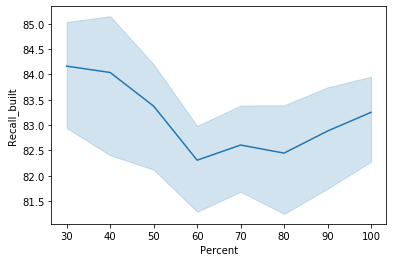

In [55]:
sns.lineplot(data=Combo_acc_with_village_df,x='Percent',y='Recall_built')

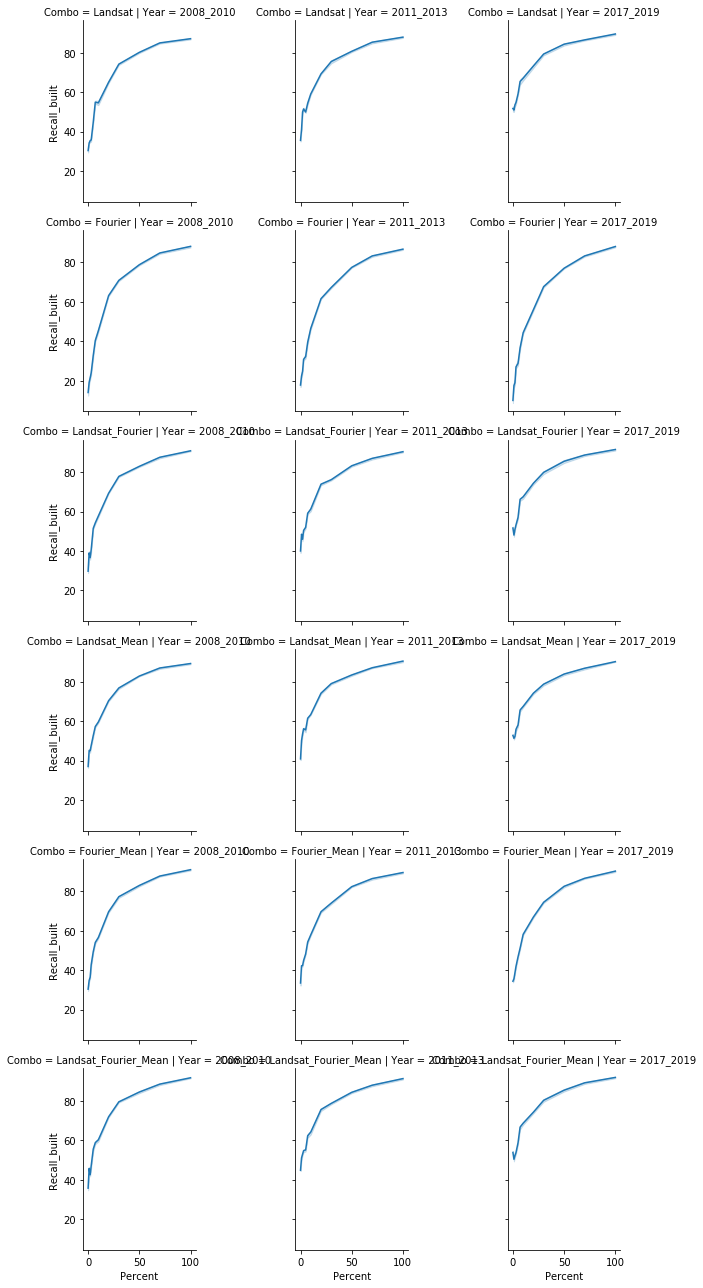

In [14]:
g = sns.FacetGrid(data = Combo_acc_df,row = 'Combo',col='Year')
g.map(sns.lineplot,'Percent','Recall_built')